In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Feature Engineering

In [145]:
df = pd.read_csv("overall.csv")
del df["Unnamed: 0"]

df['year'] = df['term'].apply(lambda x: x[0:7])
df['term'] = df['term'].apply(lambda x: x[8:])
df["before_process_vacancy"].replace(0, np.nan, inplace = True)
df.dropna(inplace = True)

sections = df.groupby(['course_code', 'year', 'term'])[['session']].count().reset_index()
sections = sections.rename({'session' : 'num_sections'}, axis = 1)

df = df.merge(sections, how = 'left', on = ['course_code', 'year', 'term'])


In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 132000 entries, 0 to 131999
Data columns (total 18 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   term                    132000 non-null  object 
 1   session                 132000 non-null  object 
 2   bidding_window          132000 non-null  object 
 3   course_code             132000 non-null  object 
 4   description             132000 non-null  object 
 5   section                 132000 non-null  object 
 6   vacancy                 132000 non-null  int64  
 7   opening_vacancy         132000 non-null  int64  
 8   before_process_vacancy  132000 non-null  float64
 9   dice                    132000 non-null  int64  
 10  after_process_vacancy   132000 non-null  int64  
 11  enrolled_students       132000 non-null  int64  
 12  median_bid              132000 non-null  float64
 13  min_bid                 132000 non-null  float64
 14  instructor          

How are the bids distributed?

In [84]:
df[['before_process_vacancy', 'median_bid', 'min_bid']].describe()

,before_process_vacancy,median_bid,min_bid
count,132000.000000,132000.000000,132000.000000
mean,8.967644,13.667979,11.634126
std,10.912530,19.857424,17.966068
min,-46.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000
50%,4.000000,0.000000,0.000000
75%,11.000000,22.530000,16.780000
max,80.000000,496.390000,480.000000


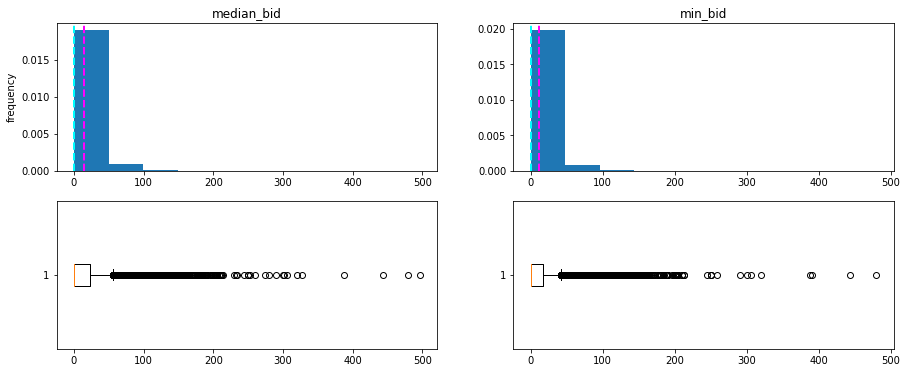

In [92]:
bids = ['median_bid', 'min_bid']

fig, ax = plt.subplots(2, 2, figsize = (15, 6))

for i in range(2):
    ax[0, i].hist(df[bids[i]], density = True)
    ax[0, i].set_title(bids[i])
    ax[1, i].boxplot(df[bids[i]], vert = False)
    ax[0, i].axvline(df[bids[i]].mean(), color='magenta', linestyle='dashed', linewidth=2)
    ax[0, i].axvline(df[bids[i]].median(), color='cyan', linestyle='dashed', linewidth=2)

ax[0, 0].set_ylabel('frequency')

plt.show()

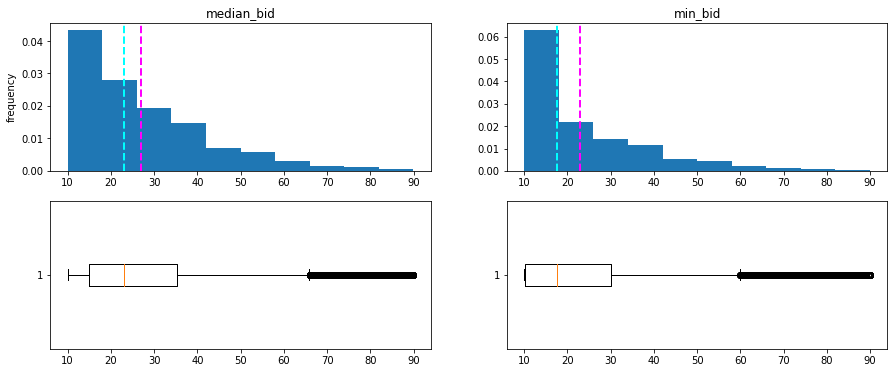

In [102]:
# Visualising it without outliers

visual = df.query('0 < median_bid < 90')

fig, ax = plt.subplots(2, 2, figsize = (15, 6))

for i in range(2):
    ax[0, i].hist(visual[bids[i]], density = True)
    ax[0, i].set_title(bids[i])
    ax[1, i].boxplot(visual[bids[i]], vert = False)
    ax[0, i].axvline(visual[bids[i]].mean(), color='magenta', linestyle='dashed', linewidth=2)
    ax[0, i].axvline(visual[bids[i]].median(), color='cyan', linestyle='dashed', linewidth=2)

ax[0, 0].set_ylabel('frequency')

plt.show()

Vacancies v. Median Bid Correlation: 4.17%
Vacancies v. Min Bid Correlation: -3.07%


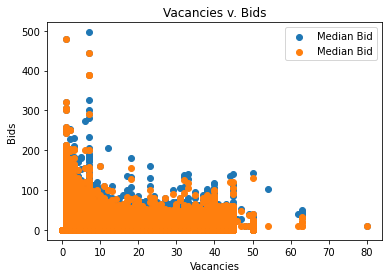

In [156]:
fig = plt.figure()
ax = fig.gca()
ax.scatter(df['before_process_vacancy'], df['median_bid'], label = 'Median Bid')
ax.scatter(df['before_process_vacancy'], df['min_bid'], label = 'Median Bid')
ax.set_xlabel('Vacancies')
ax.set_ylabel('Bids')
ax.set_title('Vacancies v. Bids')


ax.legend()

print("Vacancies v. Median Bid Correlation: {:.2%}".format(df.before_process_vacancy.corr(df.median_bid)))
print("Vacancies v. Min Bid Correlation: {:.2%}".format(df.before_process_vacancy.corr(df.min_bid)))

Some entries seem to have negative vacancies. Let's chalk those up to recording error.

In [150]:
df.loc[df['before_process_vacancy'] < 0, 'before_process_vacancy'] = 0

# Building the predictive model

In [142]:
from sklearn.linear_model import LinearRegression
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

In [154]:
X = df.iloc[:,[0, 1, 2, 3, 5, 8, 14, 15, 16, 17]]
Y = df.iloc[:, [12, 13, 10]]


#preprocessing for numeric features

numeric_features = [5]
numeric_transformer = Pipeline(steps = [
    ('scalar', StandardScaler())
])

#preprocessing for categorical features
categorical_features = [0, 1, 2, 3, 4, 6, 7, 8]
categorical_transformer = Pipeline(steps = [
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


# Combining preprocessing steps
preprocessor = ColumnTransformer(
    transformers = [
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Split the data 70%-30% into training set and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

print ('Training Set: %d rows\nTest Set: %d rows' % (X_train.shape[0], X_test.shape[0]))

Training Set: 92400 rows
Test Set: 39600 rows


In [157]:
model_log = pd.DataFrame(columns = ['model', 'r2_score'])

## Linear Regression w/o slope dummy variables

In [155]:
# Create preprocessing and training pipeline

model = Pipeline(steps = [('preprocessor', preprocessor),
                            ('regressor', LinearRegression())])

label = 'median_bid'

# fit the pipeline to train a linear regression model
model.fit(X_train, Y_train[label])

predictions = model.predict(X_test)

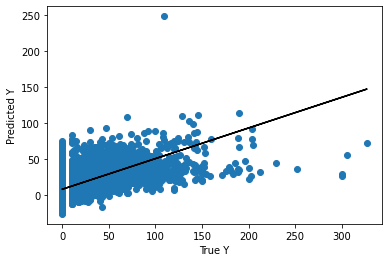

In [158]:
ax = plt.axes()
plt.scatter(x = Y_test['median_bid'], y = predictions)
ax.set_xlabel('True Y')
ax.set_ylabel('Predicted Y')
z = np.polyfit(x = Y_test['median_bid'], y = predictions, deg = 1)
p = np.poly1d(z.flatten())
plt.plot(Y_test['median_bid'], p(Y_test['median_bid']), color = 'black')

plt.show()

In [159]:
print(" R2: {:.3f}\n RMSE = {:.3f}".format(r2_score(Y_test[[label]], predictions), mean_squared_error(Y_test[[label]], predictions)**0.5))

model_log = model_log.append({
    'model': 'Linear Regression',
    'r2_score': r2_score
}, ignore_index = True)

 R2: 0.406
 RMSE = 15.182


## Decision Tree w/o Slope Dummies

In [160]:
# List of values to try for max_depth:

max_depth_range = list(range(1, 20))

# List to store the accuracy for each value of max_depth:

accuracy = []
for depth in max_depth_range:
    
    clf = Pipeline(steps = [('preprocessor', preprocessor),
                             ('regressor', tree.DecisionTreeRegressor(max_depth = depth, 
                             random_state = 0))])
    clf.fit(X_train, Y_train)
    score = clf.score(X_train, Y_train)
    accuracy.append(score)

i = accuracy.index(max(accuracy))

clf = Pipeline(steps = [('preprocessor', preprocessor),
                             ('regressor', tree.DecisionTreeRegressor(max_depth = i))])
clf = clf.fit(X_train, Y_train)

predictions = clf.predict(X_test)

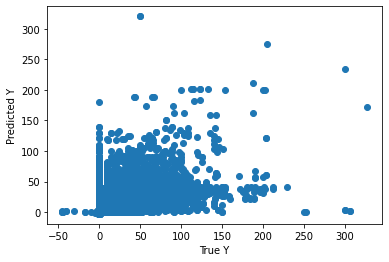

In [162]:
ax = plt.axes()
plt.scatter(Y_test, predictions)
ax.set_xlabel('True Y')
ax.set_ylabel('Predicted Y')

plt.show()

In [163]:
print(" R2: {:.3f}\n RMSE = {:.3f}".format(r2_score(Y_test, predictions), mean_squared_error(Y_test, predictions)**0.5))

model_log = model_log.append({
    'model': 'Decision Tree Regression',
    'r2_score': r2_score
}, ignore_index = True)

 R2: 0.512
 RMSE = 12.311


## Random Forest w/o Slope Dummies

In [89]:
forest = Pipeline(steps = [(
    'preprocessor', preprocessor), (
    'regressor', RandomForestRegressor()
)])

forest.fit(X_train, Y_train)

predictions = forest.predict(X_test)

C:\Users\bhara\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


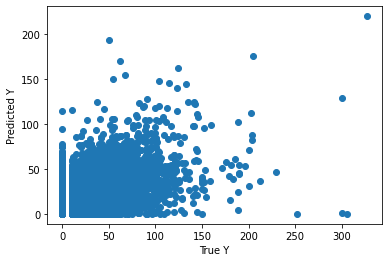

In [101]:
plt.scatter(Y_test[label], predictions)
plt.xlabel('True Y')
plt.ylabel('Predicted Y')
plt.show()

In [97]:
print(" R2: {:.3f}\n RMSE = {:.3f}".format(r2_score(Y_test[[label]], predictions), mean_squared_error(Y_test[[label]], predictions)**0.5))
model_log = model_log.append({
    'model': 'Random Forest',
    'r2_score': r2_score
}, ignore_index = True)

 R2: 0.495
 RMSE = 13.996


In this segment, I try adding a dummy slope for the categorical variables to see if they improve the 3 models

## Linear Regression w Slope Dummies

In [38]:
X = df.iloc[:,[0, 1, 2, 3, 5, 8, 14, 15, 16]]
Y = df.iloc[:, [12, 13, 10]]


#preprocessing manually since pipelining doesn't work with column mutation

numeric_transformer = StandardScaler()
num = numeric_transformer.fit_transform(X.iloc[:, [5]])

#preprocessing for categorical features
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
cat = categorical_transformer.fit_transform(X.iloc[:, [0, 1, 2, 3, 4, 6, 7, 8]]).toarray()

# Combining features
slope_dummy = np.array(cat * num)
X = np.concatenate([cat, num, slope_dummy], 1)

# Split the data 70%-30% into training set and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

print ('Training Set: %d rows\nTest Set: %d rows' % (X_train.shape[0], X_test.shape[0]))

Training Set: 92400 rows
Test Set: 39600 rows


In [29]:

model = LinearRegression()
label = 'median_bid'

# fit the linear regression model

model.fit(X_train, Y_train[label])

predictions = model.predict(X_test)

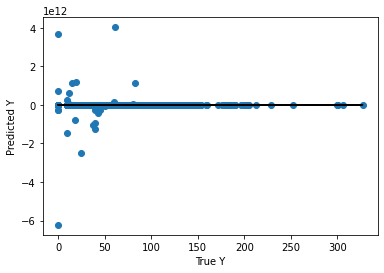

In [30]:
ax = plt.axes()
plt.scatter(x = Y_test[label], y = predictions)
ax.set_xlabel('True Y')
ax.set_ylabel('Predicted Y')
z = np.polyfit(x = Y_test[label], y = predictions, deg = 1)
p = np.poly1d(z.flatten())
plt.plot(Y_test[label], p(Y_test[label]), color = 'black')

plt.show()

This model seems to generate extreme outliers among the predicted values. Let's filter those out

In [31]:
pred = pd.DataFrame(predictions, columns = ['col'])

filter = (pred['col'] >= 0) & (pred['col'] <= 150)
true_y = Y_test.reset_index()
true_y = true_y[[label]][filter]

pred = pred[filter]

Let's try plotting the graph again with the filtered values

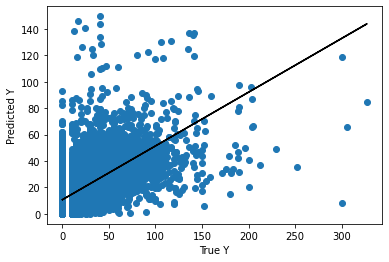

In [32]:
ax = plt.axes()
plt.scatter(x = true_y[label], y = pred)
ax.set_xlabel('True Y')
ax.set_ylabel('Predicted Y')
z = np.polyfit(x = true_y[label], y = pred, deg = 1)
p = np.poly1d(z.flatten())
plt.plot(true_y[label], p(true_y[label]), color = 'black')

plt.show()

In [33]:
print(" R2: {:.3f}\n RMSE = {:.3f}".format(r2_score(true_y[[label]], pred), mean_squared_error(true_y[[label]], pred)**0.5))

model_log = model_log.append({
    'model': 'Lin Reg w slope dummies',
    'r2_score': r2_score
}, ignore_index = True)

 R2: 0.412
 RMSE = 15.649


## Decision Tree w the Dummy Slopes

In [39]:
# Identifying max_depth is infeasible at least on my local desktop

# max_depth_range = list(range(1, 20))

# accuracy = []
# for depth in max_depth_range:
    
#     clf = tree.DecisionTreeRegressor(max_depth = depth, random_state = 0)

#     clf.fit(X_train, Y_train)
#     score = clf.score(X_train, Y_train)
#     accuracy.append(score)

# i = accuracy.index(max(accuracy))

clf = tree.DecisionTreeRegressor(random_state = 0)

clf = clf.fit(X_train, Y_train)

predictions = clf.predict(X_test)

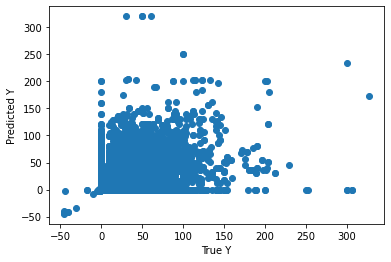

In [40]:
ax = plt.axes()
plt.scatter(Y_test, predictions)
ax.set_xlabel('True Y')
ax.set_ylabel('Predicted Y')

plt.show()

In [41]:
print(" R2: {:.3f}\n RMSE = {:.3f}".format(r2_score(Y_test, predictions), mean_squared_error(Y_test, predictions)**0.5))

model_log = model_log.append({
    'model': 'Decision Tree w slope dummies',
    'r2_score': r2_score
}, ignore_index = True)

 R2: 0.382
 RMSE = 13.949


In [132]:
# Models ranked best to worst

model_log.sort_values('r2_score', ascending = False)

,model,r2_score
1,Decision Tree Regression,0.512
2,Random Forest,0.495
3,Lin Reg w slope dummies,0.412
0,Linear Regression,0.406
4,Decision Tree w slope dummies,0.382
